In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from bmtool.util.util import load_nodes_from_paths

from analysis import plot, utils, process # imoporting analysis module enables import from model folder
import build_input

%matplotlib inline

TRIAL_NAME = "short_54"
RESULT_PATH = "simulation_results"
TRIAL_PATH = os.path.join(RESULT_PATH, TRIAL_NAME)

### Load data

In [2]:
stimulus_type, config = utils.stimulus_type_from_trial_name(TRIAL_NAME)
isstandard = stimulus_type == 'short' or stimulus_type == 'long'  # do not apply for baseline case

pop_color = plot.pop_color
pop_names = plot.pop_names

Load config from results

In [3]:
result_config_file = os.path.join('..', 'Analysis', TRIAL_PATH, config)
if not os.path.isfile(result_config_file):
    result_config_file = os.path.join(os.path.split(result_config_file)[0], utils.STIMULUS_CONFIG['else'])

config_hp = utils.ConfigHelper(result_config_file)
t_stop = config_hp.get_attr('run', 'tstop') / 1000

INPUT_PATH, _ = os.path.split(config_hp.get_attr('inputs', 'baseline_spikes', 'input_file'))
STIM_FILE = os.path.splitext(os.path.split(
    config_hp.get_attr('inputs', 'thalamus_spikes', 'input_file'))[1])[0]
NODE_FILES = config_hp.get_attr('networks', 'nodes')

Specify config directly

In [4]:
# INPUT_PATH = '../Model/input/expr/'
# STIM_FILE = 'thalamus_fade_a01_t1.0'
# NODE_FILES = [{'nodes_file': 'd:\\reserch_temp\\V1_L5_Model\\Model\\network\\cortex_nodes.h5',
#   'node_types_file': 'd:\\reserch_temp\\V1_L5_Model\\Model\\network\\cortex_node_types.csv'}]

In [5]:
SPIKE_FILE = os.path.join(INPUT_PATH, ('thalamus_' + stimulus_type if isstandard else STIM_FILE) + '.h5')
stim_file = 'standard_stimulus' if isstandard else STIM_FILE
with open(os.path.join(INPUT_PATH, stim_file + '.json')) as f:
    stim_setting = json.load(f)
stim_params = stim_setting[stimulus_type if isstandard else 'stim_params']

t_start, t_stop = stim_params['t_start'], stim_params['t_stop']
on_time, off_time = stim_params['on_time'], stim_params['off_time']
windows = process.get_stim_windows(on_time, off_time, t_start, t_stop)

In [6]:
network_name = 'cortex'
node_df = load_nodes_from_paths(NODE_FILES)[network_name]
spikes_df = utils.load_spikes_to_df(SPIKE_FILE, 'thalamus')

In [7]:
thal_ids, node_ids = build_input.input_pairs_from_file(os.path.join(INPUT_PATH, 'Assembly_ids.csv'))
node_ids = np.concatenate(node_ids)
node_df = node_df.loc[node_ids].assign(thal_id=pd.Series(np.concatenate(thal_ids), index=node_ids))
node_df = node_df.reset_index().set_index('thal_id')

In [8]:
if isstandard:
    fr_params = build_input.get_std_param(stim_setting, stimulus=stimulus_type)
else:
    fr_func = {'ramp': 'get_ramp_param', 'join': 'get_join_param', 'fade': 'get_fade_param'}
    extra_kwargs = {'join': dict(size_assemblies=[*map(len, thal_ids)])}
    params = getattr(build_input, fr_func[stimulus_type])(stim_setting, **extra_kwargs.get(stimulus_type, {}))
    fr_params = params[0]

In [9]:
if stimulus_type == 'join':
    assembly_index = params[1]['setting']['assembly_index']
    split_ids = params[2]
    group_ids = thal_ids.copy()
    for i, s_idx in sorted(zip(assembly_index, split_ids), reverse=True):
        ids = group_ids.pop(i)
        group_ids[i:i] = [ids[idx] for idx in s_idx]
else:
    group_ids = thal_ids

In [10]:
z_5A = 0.  # boundary between 5A and 5B
sorted_groups = [[], []] # differentiate 5B and 5A
for grp in group_ids:
    grp = np.asarray(grp)
    idx_5A = node_df.loc[grp, 'pos_z'] >= z_5A
    sorted_groups[0].append(grp[~idx_5A])
    sorted_groups[1].append(grp[idx_5A])

sorted_ids = pd.Series(-1, index=node_df.index)
for i, thal_id in enumerate(np.concatenate(sum(sorted_groups, []))):
    sorted_ids[thal_id] = i

node_df['sorted_id'] = sorted_ids
spikes_df['sorted_id'] = node_df.loc[spikes_df['node_ids'], 'sorted_id'].values

### Designed input firing rate traces

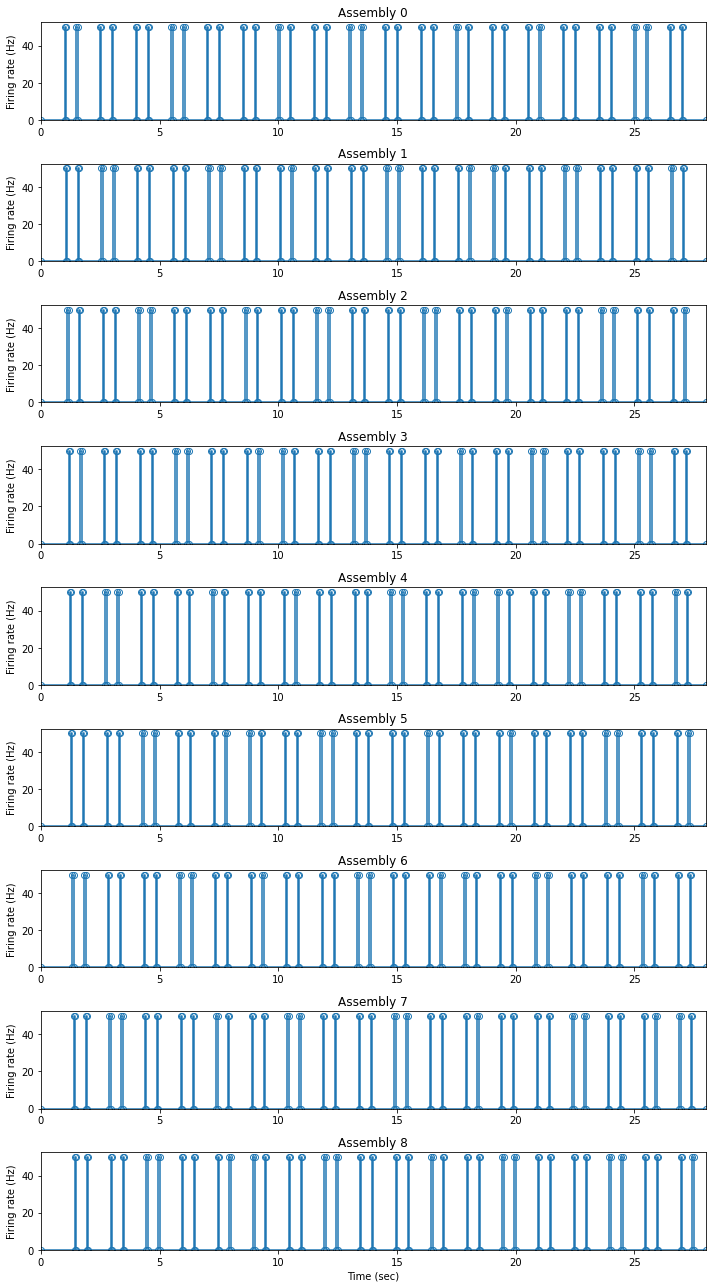

In [11]:
_ = build_input.plot_fr_traces(fr_params)
plt.show()

### Thalamus input spike raster

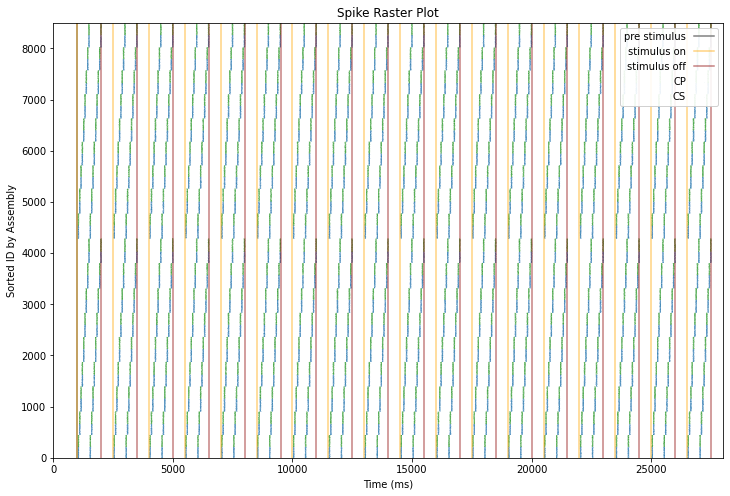

In [12]:
# %matplotlib notebook

spikes_df['pop_name'] = node_df.loc[spikes_df['node_ids'], 'pop_name'].values
pop_spike = build_input.get_populations(spikes_df, node_df['pop_name'].unique())

_, ax = plt.subplots(1, 1, figsize=(12, 8))
plot.raster(pop_spike, pop_color, id_column='sorted_id', s=0.0001, ax=ax)
ax.axvline(t_start * 1000, color='gray', label='pre stimulus')
for i, win in enumerate(windows):
    labels = [None, None] if i else ['stimulus on', 'stimulus off']
    ax.axvline(win[0] * 1000, color='orange', alpha=0.5, label=labels[0])
    ax.axvline(win[1] * 1000, color='darkred', alpha=0.5, label=labels[1])
ax.set_ylabel('Sorted ID by Assembly')
ax.legend(loc='upper right', framealpha=0.9, markerfirst=False)
ax.set_xlim([0, 1000 * t_stop])
# ax.set_xlim([0, 1.1 * spikes_df['timestamps'].max()])
ax.set_ylim([node_df.index.min() - 1, node_df.index.max() + 1])
plt.show()